# Get reading from image using OpenCV-Python
Writen by Lei Lei<br>
Faculty of Engineering, University of Nottingham

Input image directory, make output directory, load image.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray'

Define a crop function. Reshape and crop the image to save computation efforts.

In [2]:
def rescaleFrame(frame, scale = 0.3):
    width = int(frame.shape[1]*scale)
    height = int(frame.shape[0]*scale)
    dimensions = (width, height)  
    return cv2.resize(frame, dimensions, interpolation = cv2.INTER_AREA)

In [3]:
# Reading Video
capture=cv2.VideoCapture('/mnt/c/users/stcik/scire/papers/muon/84C.MOV')
count = 0
success = True
fps = int(capture.get(cv2.CAP_PROP_FPS))
out_folder='/mnt/c/users/stcik/scire/papers/muon/84C/frames'
os.makedirs(out_folder,exist_ok=True)
while success:
    success, image = capture.read()
    if count%(1*fps) == 0 :
        image = rescaleFrame(image)
        cv2.imwrite(os.path.join(out_folder,'frame%d.jpg'%count),image)
#         print('Successfully written frame%d!'%count)
    count+=1

In [4]:
def crop(img, params = (200, 400, 160, 300)):
    # Parameters in the order of y, h, x, w
    new_image = img[params[0]:params[1], params[2]:params[3]]
    return new_image

In [5]:
def plot(image, cmap=None):
    plt.axis('off')
    plt.imshow(image)

Batch reshape & crop frames.

In [6]:
import re
rDir = r'./frames'
out_folder='cropped'
os.makedirs(out_folder,exist_ok=True)
savs=[]
for file in os.listdir(rDir):
    if file.endswith(".jpg"):
        savs.append(os.path.join(rDir, file))

for sav in savs:
    image_path=sav
    image=cv2.imread(image_path)
    new_image=crop(image, width=500, y=190, h=400, x=90, w=330)
    name = image_path.split('/')[-1]
    cv2.imwrite(os.path.join(out_folder, f'90C_{name}.jpg'), new_image)

Mannual crop some frames, where camera moved a lot

In [42]:
image_path=r'./frames/frame2320.jpg'
image=cv2.imread(image_path)
new_image = crop(image, width=500, y=120, h=430, x=60, w=370)
name = image_path.split('/')[-1]
cv2.imwrite(os.path.join(out_folder, f'100C_{name}'), new_image)

True

Define functions to detect text box.

In [234]:
def make_bin(img, gmin=190, gmax=255):
    """Make a binary image from the cropped image."""
    # Thresholding the image
    (thresh, img_bin) = cv2.threshold(img, gmin, gmax, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Invert the image
    img_bin = 255-img_bin
    cv2.imwrite("Images/Image_bin.jpg", img_bin)
#     plt.axis('off')
#     plt.imshow(img_bin)
    return img_bin

def get_lines(img, verticle_kernel, hori_kernel):
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
    cv2.imwrite("Images/verticle_lines.jpg", verticle_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
    cv2.imwrite("Images/horizontal_lines.jpg", horizontal_lines_img)
#     plt.subplot(1, 2, 1)  # 2 rows, 2 columns, 1st subplot = top left
#     plt.imshow(verticle_lines_img);
#     plt.axis('off')

#     plt.subplot(1, 2, 2)  # 2 rows, 2 columns, 2nd subplot = top right
#     plt.imshow(horizontal_lines_img);
#     plt.axis('off')
    return verticle_lines_img, horizontal_lines_img

def combine(img1, img2, alpha, beta):
    """Combine the horizontal and vertical lines
    alpha and beta are weighting parameters, this will decide the quantity of an image to be added to make a new image."""
    img_final_bin = cv2.addWeighted(img1, alpha, img2, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 125,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#     plt.axis('off')
#     plt.imshow(img_final_bin)
    return img_final_bin

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def get_reading(img, contours, folder):
    xpos=[]
    ypos=[]
    wlist=[]
    hlist=[]
    width, height = img.shape
    for c in contours:
        # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        # If a box height is greater then 20 & widht is greater then 20 and 0.8*h > w > 0.40*h, add it's position info in the empty lists.
        if (0.85*width > (x+w)/2 > 0.25*width and 0.78*height > (y+h)/2 > 0.30*height) and 0.75 > w/h > 0.20:
            xpos.append(x)
            ypos.append(y)
            wlist.append(w)
            hlist.append(h)
    new_img = img[np.array(ypos).min():np.array(ypos).min()+np.array(hlist).max(), int(0.3*width):int(0.85*width)]
#     print(np.array(ypos).min(),np.array(ypos).max()+np.array(hlist).max(), np.array(xpos).min(),np.array(xpos).max()+np.array(wlist).max())
#     plt.imshow(new_img)
#     plt.axis('off')
    name = image_path.split('/')[-1]
    cv2.imwrite(os.path.join(folder, f'temp_{name}'), new_img)

Batch process the frames, save the detecte region into ./outs directory.

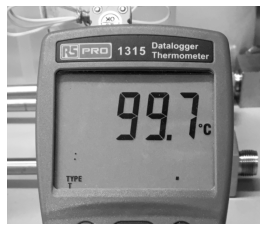

In [142]:
alpha = 0.5
beta = 1.0 - alpha
image_path=r'./test.jpg'
image=cv2.imread(image_path)
image=crop(image, width=500, y=650, h=1900, x=650, w=2100)
plot(image)

In [143]:
# Defining a kernel length
kernel_length = np.array(image).shape[1]//100
# print(kernel_length)
# A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
img_bin=make_bin(image)
verticle_lines_img, horizontal_lines_img = get_lines(img_bin, verticle_kernel = verticle_kernel, hori_kernel = hori_kernel)
img_final_bin=combine(verticle_lines_img, horizontal_lines_img, alpha = alpha, beta = beta)

In [144]:
# Find contours for image, which will detect all the boxes
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#Create box-list
box = []
# Get position (x,y), width and height for every contour 
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    width, height = image.shape
    if (0.85*width > x > 0.2*width and 0.78*height > y > 0.25*height) and 0.75 > w/h > 0.20:
        box.append([x,y,w,h])
print(box)

[[317, 251, 8, 19], [339, 168, 44, 99], [270, 167, 54, 103], [290, 184, 16, 26], [212, 167, 54, 102], [232, 183, 17, 27]]


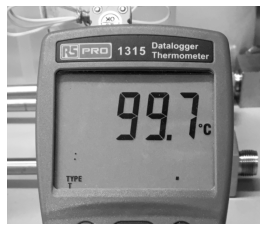

In [145]:
plot(image)

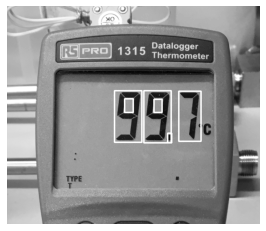

In [146]:
for n in box:
    img_box = cv2.rectangle(image, (n[0],n[1]), (n[0]+n[2],n[1]+n[3]), (255,0,0), 2)
plot(img_box)

In [101]:
out_folder=r'./outs'
os.makedirs(out_folder,exist_ok=True)
# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
get_reading(image, contours = contours, folder = out_folder)

In [263]:
# Set up the parameters to find horizontal and vertical lines.
alpha = 0.5
beta = 1.0 - alpha
savs=[]
rDir = r'./cropped'
out_folder=r'./outs'

for file in os.listdir(rDir):
    if file.endswith(".jpg"):
        savs.append(os.path.join(rDir,file))
# counts=1
for i, sav in enumerate(savs):
        image=cv2.imread(sav, cv2.IMREAD_GRAYSCALE)
        width, height = image.shape
        new_img = image[int(0.*height):int(0.66*height), int(0.39*width): int(0.94*width)]
        name = sav.split('/')[-1]
        cv2.imwrite(os.path.join(out_folder, f'temp_{name}'), new_img)

In [235]:
# Set up the parameters to find horizontal and vertical lines.
alpha = 0.5
beta = 1.0 - alpha
savs=[]
rDir = r'./cropped'
out_folder=r'./outs'

for file in os.listdir(rDir):
    if file.endswith(".jpg"):
        savs.append(os.path.join(rDir,file))
# counts=1
for sav in savs:
    image_path=sav
    image=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Defining a kernel length
    kernel_length = np.array(image).shape[1]//100
#     print(kernel_length)
    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_bin=make_bin(image)
    verticle_lines_img, horizontal_lines_img = get_lines(img_bin, verticle_kernel = verticle_kernel, hori_kernel = hori_kernel)
    img_final_bin=combine(verticle_lines_img, horizontal_lines_img, alpha = alpha, beta = beta)
    # Find contours for image, which will detect all the boxes
    contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Sort all the contours by top to bottom.
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
    get_reading(image, contours = contours, folder = out_folder)

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


ValueError: zero-size array to reduction operation minimum which has no identity

In [4]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [5]:
# We will use the size and position of the contourbox to filter the boxes.
def get_reading(img, contours):
    # Get the width and height of the image
    height, width = img.shape
#     print(width, height)
    textcont=[]
    for c in contours:
        # Returns the location and width, height for every contour
        x, y, w, h = cv2.boundingRect(c)
        # We will only use the height of the numbers, because all numbers have about the same height but 1 is much narrower than other numbers.
        # We will only use the y positions, because the x positions has a larger distribution.
        if 0.3 > h/height > 0.08 and (4*(height-y-h) > y > 0.40*(height-y-h) and 0.30*width < x < 0.92*width):
            textcont.append(c)
#             print(x, y, w, h, h/height, y/(height-y-h))
    return textcont

In [6]:
line_min_width = 8
kernal_h = np.ones((3,line_min_width), np.uint8)
kernal_v = np.ones((line_min_width,3), np.uint8)

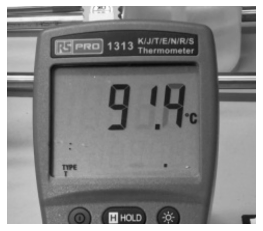

In [136]:
image_path=r'/mnt/c/users/stcik/scire/papers/muon/90C/cropped/90C_frame1479.jpg.jpg'
new_image=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plot(new_image)

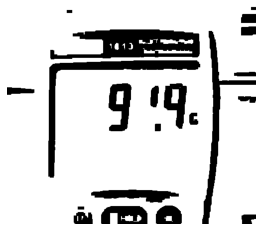

In [131]:
img_bin=make_bin(new_image, gmin=80, gmax=195)
img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
img_bin_final=img_bin_h|img_bin_v
final_kernel = np.ones((4,4), np.uint8)
img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
img_bin_final=~img_bin_final
plot(img_bin_final)

In [132]:
#Retrieve contours 
contours, hierarchy = cv2.findContours(img_bin_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
textcont = get_reading(new_image, contours)
textbox = []
for c in textcont:
    x, y, w, h = cv2.boundingRect(c)
    textbox.append([x,y,w,h])
print(textbox)

[[287, 159, 19, 45], [314, 154, 48, 93], [203, 154, 48, 98]]


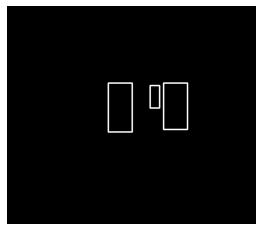

In [137]:
img_box = np.zeros(new_image.shape, dtype = "uint8")
for n in textbox:
    img_box = cv2.rectangle(img_box, (n[0],n[1]), (n[0]+n[2],n[1]+n[3]), (255,0,0), 2)
plot(img_box)

154 252 198 362


True

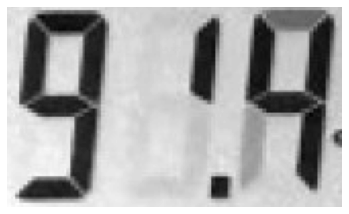

In [138]:
textcont, textboxes = sort_contours(textcont, method="left-to-right")
xpos, xwidth = textboxes[0][0]-5, textboxes[-1][0]+textboxes[-1][2]
textcont, textboxes = sort_contours(textcont, method="top-to-bottom")
ypos, yheight = textboxes[0][1], textboxes[0][1]+textboxes[0][3]
print(ypos, yheight, xpos, xwidth)
new_image = new_image[ypos:yheight, xpos:xwidth]
name = image_path.split('/')[-1]
plot(new_image)
cv2.imwrite(f'/mnt/c/users/stcik/scire/papers/muon/90C/newouts/{name}', new_image)

In [9]:
nums = range(5597,5655,29)
for num in nums:
    num = str(num)
    image_path=f'/mnt/c/users/stcik/scire/papers/muon/90C/cropped/90C_frame{num}.jpg.jpg'
    image=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_bin=make_bin(image, gmin=90, gmax=180)
    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
    img_bin_final=img_bin_h|img_bin_v
    final_kernel = np.ones((1,1), np.uint8)
    img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
    img_bin_final=~img_bin_final
    #     plot(img_bin_final)
    contours, hierarchy = cv2.findContours(img_bin_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    textcont = get_reading(image, contours)
    textcont, textboxes = sort_contours(textcont, method="left-to-right")
    xpos, xwidth = textboxes[0][0], textboxes[-1][0]+textboxes[-1][2]+5
    textcont, textboxes = sort_contours(textcont, method="top-to-bottom")
    ypos, yheight=textboxes[0][1], textboxes[-1][1]+textboxes[-1][3]+2
#     print(ypos, yheight, xpos, xwidth)
    new_image = image[ypos:yheight, xpos:xwidth]
    name = image_path.split('/')[-1]
    #     plot(new_image)
    cv2.imwrite(f'/mnt/c/users/stcik/scire/papers/muon/90C/newouts/{name}', new_image)

In [7]:
def make_bin(img, gmin=90, gmax=180):
    # Thresholding the image
    (thresh, img_bin) = cv2.threshold(img,gmin, gmax, cv2.THRESH_BINARY)
    # Invert the image
    img_bin = ~img_bin
    return img_bin

In [165]:
rDir = r'/mnt/c/users/stcik/scire/papers/muon/90C/newouts'
out_folder='/mnt/c/users/stcik/scire/papers/muon/90C/binary'
os.makedirs(out_folder,exist_ok=True)

for file in os.listdir(rDir):
        image_path=os.path.join(rDir,file)
        image=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img_bin=make_bin(image)
        name = image_path.split('/')[-1]
        cv2.imwrite(os.path.join(out_folder, f'{name}'), img_bin)

The binary files are renamed by the `rename.ps1` powershell script so that the file names are treated naturally and match the order displayed in the folder.

In [176]:
#90 C readings
readings=[90.6,90.2,90.4,90.4,89.9,89.4,89.4,88.9,89.3,89.3,89.6,
         90.1,90.1,90.1,90.1,90.5,90.5,90.7,90.9,90.9,91.2,91.0,
         91.0,90.9,90.9,91.3,91.3,91.3,91.3,91.4,91.4,91.3,91.3,
         91.7,91.7,91.8,91.9,91.9,92.2,92.5,92.5,92.7,92.6,92.6,
         92.6,92.7,92.7,92.7,92.7,92.3,92.4,91.9,91.8,91.8,91.2,
         91.2,91.2,91.3,91.3,91.4,91.0,91.0,90.8,90.7,90.7,91.3,
         91.6,91.8,91.8,91.8,91.8,92.3,92.2,92.2,92.1,92.2,92.2,
         92.4,91.9,91.9,91.3,91.1,91.1,90.9,90.9,91.0,91.0,90.6,
         90.2,90.2,89.9,89.5,89.5,89.0,89.0,89.3,89.8,89.8,89.9,
         89.8,89.8,89.3,89.0,89.0,88.8,88.6,89.0,89.0,89.3,89.3,
         89.3,89.4,90.0,90.0,90.1,90.4,90.4,90.8,90.8,91.1,91.3,
         91.3,90.6,90.2,90.2,89.9,90.5,90.8,90.8,90.9,91.1,91.1,
         91.0,90.7,90.7,91.1,91.5,91.5,91.6,91.6,91.5,91.5,91.5,
         91.4,92.1,92.1,91.9,91.9,92.4,92.4,92.2,91.6,91.6,91.3,
         91.3,91.3,90.9,90.9,90.9,90.8,90.7,90.5,90.5,90.9,91.4,
         91.4,91.4,91.7,91.7,91.7,91.7,91.7,91.4,91.4,91.1,90.7,
         90.7,90.4,90.3,90.3,90.4,90.4,90.6,90.6,90.9,91.3,91.3,
         91.3,91.3,91.3,91.3,91.3,91.3,90.9,90.9]
print(len(readings))

195


In [183]:
# 75 C readings
readings=[75.2,75.0,74.9,74.9,74.9,74.8,74.8,74.8,74.8,74.7,74.7,
         74.9,75.1,75.1,75.2,75.2,75.2,75.2,75.4,75.4,75.6,75.6,
         75.6,75.7,75.7,75.7,75.6,75.6,75.6,75.6,75.6,75.6,75.5,
         75.4,75.4,75.4,75.4,75.4,75.4,75.5,75.5,75.5,75.6,75.6,
         75.6,75.6,75.6,75.6,75.6,75.7,75.6,75.6,75.6,75.4,75.3,
         75.3,75.4,75.4,75.4,75.5,75.7,75.7,75.7,75.8,75.6,75.6,
         75.3,75.2,75.2,75.2,75.6,75.6,75.6,75.6,75.1,75.0,75.0,
         75.6,75.6,75.6,75.7,75.8,75.8,75.9,76.1,75.9,75.9,75.8,
         75.8,75.8,75.8,75.9,75.9,76.0,76.0,76.1,76.1,76.1,76.2,
         76.2,76.2,76.3,76.2,76.2,76.0,76.0,75.8,75.8,75.8,75.7,
         75.7,75.8,75.7,75.7,75.6,75.6,75.6,75.5,75.5,75.6,75.8,
         75.8,75.8,75.8,75.8,75.8,75.8,75.7,75.7,75.8,75.9,75.9,
         75.8,75.9,75.9,75.9,75.8,75.8,76.0,76.2,76.2,76.2,76.2,
         76.0,76.0,76.0,76.0,75.8,75.9,75.9,75.8,76.0,76.0,75.9,
         76.0,76.0,76.1,76.1,76.1,76.1,76.0,75.9,75.9,75.8,75.8,
         75.8,75.9,75.9,75.8,75.8,75.8,75.7,75.8,75.8,75.8,75.8,
         75.8,75.9,75.9,75.9,75.9,76.0,76.0,76.0,76.1,76.1,76.1,
         76.1,76.1,76.2,76.3,76.3,76.1,76.1,76.1,76.0,75.8,75.8,
         75.8,75.8,75.8,75.8,75.8,75.8,75.8,75.8,75.8,75.8,75.7,
         75.7,75.7,75.7,75.7,75.7,75.7,75.7]
print(len(readings))

216


In [185]:
# Add 120 C readings as training data
readings=[119.4,119.8,119.9,120.3,120.3,120.7,120.6,120.6,120.8,121.2,121.2,
         121.3,120.8,120.7,120.7,120.4,120.4,120.8,120.8,120.8,121.0,121.4,
         121.4,121.8,122.2,122.2,121.6,121.9,121.9,121.7,121.7,121.7,121.8,
         121.7,121.7,120.0,118.8,119.6,119.6,119.8,119.8,118.9,118.1,118.1,
         117.9,118.8,118.8,119.3,119.8,119.8,120.3,120.5,120.5,120.8,120.4,
         120.4,120.3,120.3,120.5,120.5,118.5,118.2,118.2,118.6,118.6,118.0,
         118.5,118.5,118.9,118.9,118.9,118.7,117.5,117.5,116.8,118.0,118.6,
         118.6,118.9,117.6,117.6,117.8,118.2,118.2,117.3,116.0,116.0,115.4,
         115.4,116.6,117.4,117.4,118.1,118.7,119.7,119.4,119.6,120.2,120.2,
         120.4,120.4,120.4,120.4,119.9,119.9,119.6,119.7,119.7,119.7,120.1,
         120.7,120.5,120.5,121.1,121.0,121.0,120.6,120.8,121.1,120.1,121.2,
         121.3,121.3,121.1,121.1,121.1,121.3,121.4,121.4,121.1,121.1,120.7,
         120.7,121.1,121.4,121.4,121.4,121.9,121.3,120.9,120.9,120.3,120.6,
         120.6,120.6,118.9,118.9,118.6,118.7,119.1,119.4,120.1,119.6,119.6,
         119.8,118.6,118.6,118.8,119.6,119.6,120.4,120.4,120.4,120.4,120.4,
         120.4,120.4,120.4,120.4,120.4,120.4,120.4,120.4,120.4,120.4,120.4,
         120.4,120.4,120.4,120.4,121.1,120.9,121.1,121.1,121.1,121.1,118.7,
         119.1,119.1,119.4,119.5,119.1,120.1,119.9,119.6,119.6,118.2,118.9,
         118.9,118.3,118.9,118.9,118.8,119.3,119.5,119.5,119.6,119.6,120.1,
         120.1,119.8,120.1,120.1,120.6,120.6,120.6,120.9,121.2,121.1,121.1,
         121.4,121.8,121.8,122.2,122.6,112.6,122.6,122.7,122.8,122.8,122.8,
         122.8,122.5,122.5,122.6,122.2,122.4,122.4,122.4,122.3,122.3,122.4,
         122.1,122.1,121.9,121.8,121.2,121.2,117.3,120.7,120.7]
print(len(readings))

251


In [172]:
print(len(readings))

216


In [186]:
# 75, 90, 100,120 data as train data
readings=[75.2,75.0,74.9,74.9,74.9,74.8,74.8,74.8,74.8,74.7,74.7,
         74.9,75.1,75.1,75.2,75.2,75.2,75.2,75.4,75.4,75.6,75.6,
         75.6,75.7,75.7,75.7,75.6,75.6,75.6,75.6,75.6,75.6,75.5,
         75.4,75.4,75.4,75.4,75.4,75.4,75.5,75.5,75.5,75.6,75.6,
         75.6,75.6,75.6,75.6,75.6,75.7,75.6,75.6,75.6,75.4,75.3,
         75.3,75.4,75.4,75.4,75.5,75.7,75.7,75.7,75.8,75.6,75.6,
         75.3,75.2,75.2,75.2,75.6,75.6,75.6,75.6,75.1,75.0,75.0,
         75.6,75.6,75.6,75.7,75.8,75.8,75.9,76.1,75.9,75.9,75.8,
         75.8,75.8,75.8,75.9,75.9,76.0,76.0,76.1,76.1,76.1,76.2,
         76.2,76.2,76.3,76.2,76.2,76.0,76.0,75.8,75.8,75.8,75.7,
         75.7,75.8,75.7,75.7,75.6,75.6,75.6,75.5,75.5,75.6,75.8,
         75.8,75.8,75.8,75.8,75.8,75.8,75.7,75.7,75.8,75.9,75.9,
         75.8,75.9,75.9,75.9,75.8,75.8,76.0,76.2,76.2,76.2,76.2,
         76.0,76.0,76.0,76.0,75.8,75.9,75.9,75.8,76.0,76.0,75.9,
         76.0,76.0,76.1,76.1,76.1,76.1,76.0,75.9,75.9,75.8,75.8,
         75.8,75.9,75.9,75.8,75.8,75.8,75.7,75.8,75.8,75.8,75.8,
         75.8,75.9,75.9,75.9,75.9,76.0,76.0,76.0,76.1,76.1,76.1,
         76.1,76.1,76.2,76.3,76.3,76.1,76.1,76.1,76.0,75.8,75.8,
         75.8,75.8,75.8,75.8,75.8,75.8,75.8,75.8,75.8,75.8,75.7,
         75.7,75.7,75.7,75.7,75.7,75.7,75.7,90.6,90.2,90.4,90.4,89.9,89.4,89.4,88.9,89.3,89.3,89.6,
         90.1,90.1,90.1,90.1,90.5,90.5,90.7,90.9,90.9,91.2,91.0,
         91.0,90.9,90.9,91.3,91.3,91.3,91.3,91.4,91.4,91.3,91.3,
         91.7,91.7,91.8,91.9,91.9,92.2,92.5,92.5,92.7,92.6,92.6,
         92.6,92.7,92.7,92.7,92.7,92.3,92.4,91.9,91.8,91.8,91.2,
         91.2,91.2,91.3,91.3,91.4,91.0,91.0,90.8,90.7,90.7,91.3,
         91.6,91.8,91.8,91.8,91.8,92.3,92.2,92.2,92.1,92.2,92.2,
         92.4,91.9,91.9,91.3,91.1,91.1,90.9,90.9,91.0,91.0,90.6,
         90.2,90.2,89.9,89.5,89.5,89.0,89.0,89.3,89.8,89.8,89.9,
         89.8,89.8,89.3,89.0,89.0,88.8,88.6,89.0,89.0,89.3,89.3,
         89.3,89.4,90.0,90.0,90.1,90.4,90.4,90.8,90.8,91.1,91.3,
         91.3,90.6,90.2,90.2,89.9,90.5,90.8,90.8,90.9,91.1,91.1,
         91.0,90.7,90.7,91.1,91.5,91.5,91.6,91.6,91.5,91.5,91.5,
         91.4,92.1,92.1,91.9,91.9,92.4,92.4,92.2,91.6,91.6,91.3,
         91.3,91.3,90.9,90.9,90.9,90.8,90.7,90.5,90.5,90.9,91.4,
         91.4,91.4,91.7,91.7,91.7,91.7,91.7,91.4,91.4,91.1,90.7,
         90.7,90.4,90.3,90.3,90.4,90.4,90.6,90.6,90.9,91.3,91.3,
         91.3,91.3,91.3,91.3,91.3,91.3,90.9,90.9,99.8,100.0,100.3,100.3,100.3,100.2,100.2,100.2,100.4,100.4,100.4,
         100.6,100.8,100.8,101.0,101.1,101.1,101.3,101.3,101.3,101.2,101.1,
         100.9,100.9,100.5,100.5,100.2,100.3,100.3,100.4,100.4,100.4,100.4,
         100.6,100.6,100.4,100.3,100.2,100.1,100.1,100.1,100.2,100.4,100.4,
         100.3,100.2,100.2,100.3,100.3,100.2,99.7,99.7,99.6,99.2,99.2,
         98.7,98.2,98.4,98.4,98.6,98.8,98.8,98.8,98.8,98.8,99.0,
         99.0,99.0,99.0,99.1,99.1,99.2,99.2,99.6,99.8,99.8,99.6,
         99.6,99.6,99.8,100.1,100.2,100.2,100.2,100.5,100.5,100.7,100.7,
         100.7,100.6,100.4,100.1,100.1,100.2,100.2,99.9,99.9,100.4,100.4,
         100.4,100.5,100.5,100.2,100.2,100.3,100.4,100.4,100.5,100.7,100.7,
         100.7,100.8,100.8,100.8,100.8,100.8,100.8,100.9,100.9,101.1,101.1,
         101.0,100.9,100.9,100.9,100.9,100.8,100.8,100.4,100.0,100.0,99.8,
         99.9,99.9,100.0,100.2,100.2,100.2,100.2,100.2,100.2,101.1,100.1,
         99.9,99.4,99.4,99.4,99.3,99.3,99.4,99.4,99.4,99.8,100.2,
         100.3,100.5,100.6,100.6,100.6,100.8,100.8,100.8,100.5,100.7,100.7,
         100.8,100.8,100.8,101.0,101.0,100.9,100.9,101.3,101.2,100.6,100.6,
         100.6,100.7,100.9,100.9,100.8,100.9,100.9,100.8,100.8,100.9,100.9,
         101.1,101.1,101.3,101.3,101.4,101.4,101.4,119.4,119.8,119.9,120.3,120.3,120.7,120.6,120.6,120.8,121.2,121.2,
         121.3,120.8,120.7,120.7,120.4,120.4,120.8,120.8,120.8,121.0,121.4,
         121.4,121.8,122.2,122.2,121.6,121.9,121.9,121.7,121.7,121.7,121.8,
         121.7,121.7,120.0,118.8,119.6,119.6,119.8,119.8,118.9,118.1,118.1,
         117.9,118.8,118.8,119.3,119.8,119.8,120.3,120.5,120.5,120.8,120.4,
         120.4,120.3,120.3,120.5,120.5,118.5,118.2,118.2,118.6,118.6,118.0,
         118.5,118.5,118.9,118.9,118.9,118.7,117.5,117.5,116.8,118.0,118.6,
         118.6,118.9,117.6,117.6,117.8,118.2,118.2,117.3,116.0,116.0,115.4,
         115.4,116.6,117.4,117.4,118.1,118.7,119.7,119.4,119.6,120.2,120.2,
         120.4,120.4,120.4,120.4,119.9,119.9,119.6,119.7,119.7,119.7,120.1,
         120.7,120.5,120.5,121.1,121.0,121.0,120.6,120.8,121.1,120.1,121.2,
         121.3,121.3,121.1,121.1,121.1,121.3,121.4,121.4,121.1,121.1,120.7,
         120.7,121.1,121.4,121.4,121.4,121.9,121.3,120.9,120.9,120.3,120.6,
         120.6,120.6,118.9,118.9,118.6,118.7,119.1,119.4,120.1,119.6,119.6,
         119.8,118.6,118.6,118.8,119.6,119.6,120.4,120.4,120.4,120.4,120.4,
         120.4,120.4,120.4,120.4,120.4,120.4,120.4,120.4,120.4,120.4,120.4,
         120.4,120.4,120.4,120.4,121.1,120.9,121.1,121.1,121.1,121.1,118.7,
         119.1,119.1,119.4,119.5,119.1,120.1,119.9,119.6,119.6,118.2,118.9,
         118.9,118.3,118.9,118.9,118.8,119.3,119.5,119.5,119.6,119.6,120.1,
         120.1,119.8,120.1,120.1,120.6,120.6,120.6,120.9,121.2,121.1,121.1,
         121.4,121.8,121.8,122.2,122.6,112.6,122.6,122.7,122.8,122.8,122.8,
         122.8,122.5,122.5,122.6,122.2,122.4,122.4,122.4,122.3,122.3,122.4,
         122.1,122.1,121.9,121.8,121.2,121.2,117.3,120.7,120.7]
print(len(readings))

856


In [187]:
rDir = r'/mnt/c/users/stcik/scire/papers/muon/deep-text-recognition-benchmark/data/test'
savs=[]

for file in os.listdir(rDir):
    if file.endswith(".jpg"):
        savs.append(os.path.join(rDir,file))

data = [savs, readings]

with open('/mnt/c/users/stcik/scire/papers/muon/deep-text-recognition-benchmark/data/gt.txt', 'w') as f:
    for x in zip(*data):
        f.write("{0}\t{1}\n".format(*x))
print('Data saved!')
f.close()

Data saved!


In [189]:
# Create my lmdb dataset with the picture files and gt.txt files
!python3 /mnt/c/users/stcik/scire/papers/muon/deep-text-recognition-benchmark/create_lmdb_dataset.py --inputPath /mnt/c/Users/stcik/scire/papers/muon/deep-text-recognition-benchmark/data/ --gtFile /mnt/c/Users/stcik/scire/papers/muon/deep-text-recognition-benchmark/data/gt.txt --outputPath /mnt/c/Users/stcik/scire/papers/muon/deep-text-recognition-benchmark/result/train

Created dataset with 856 samples


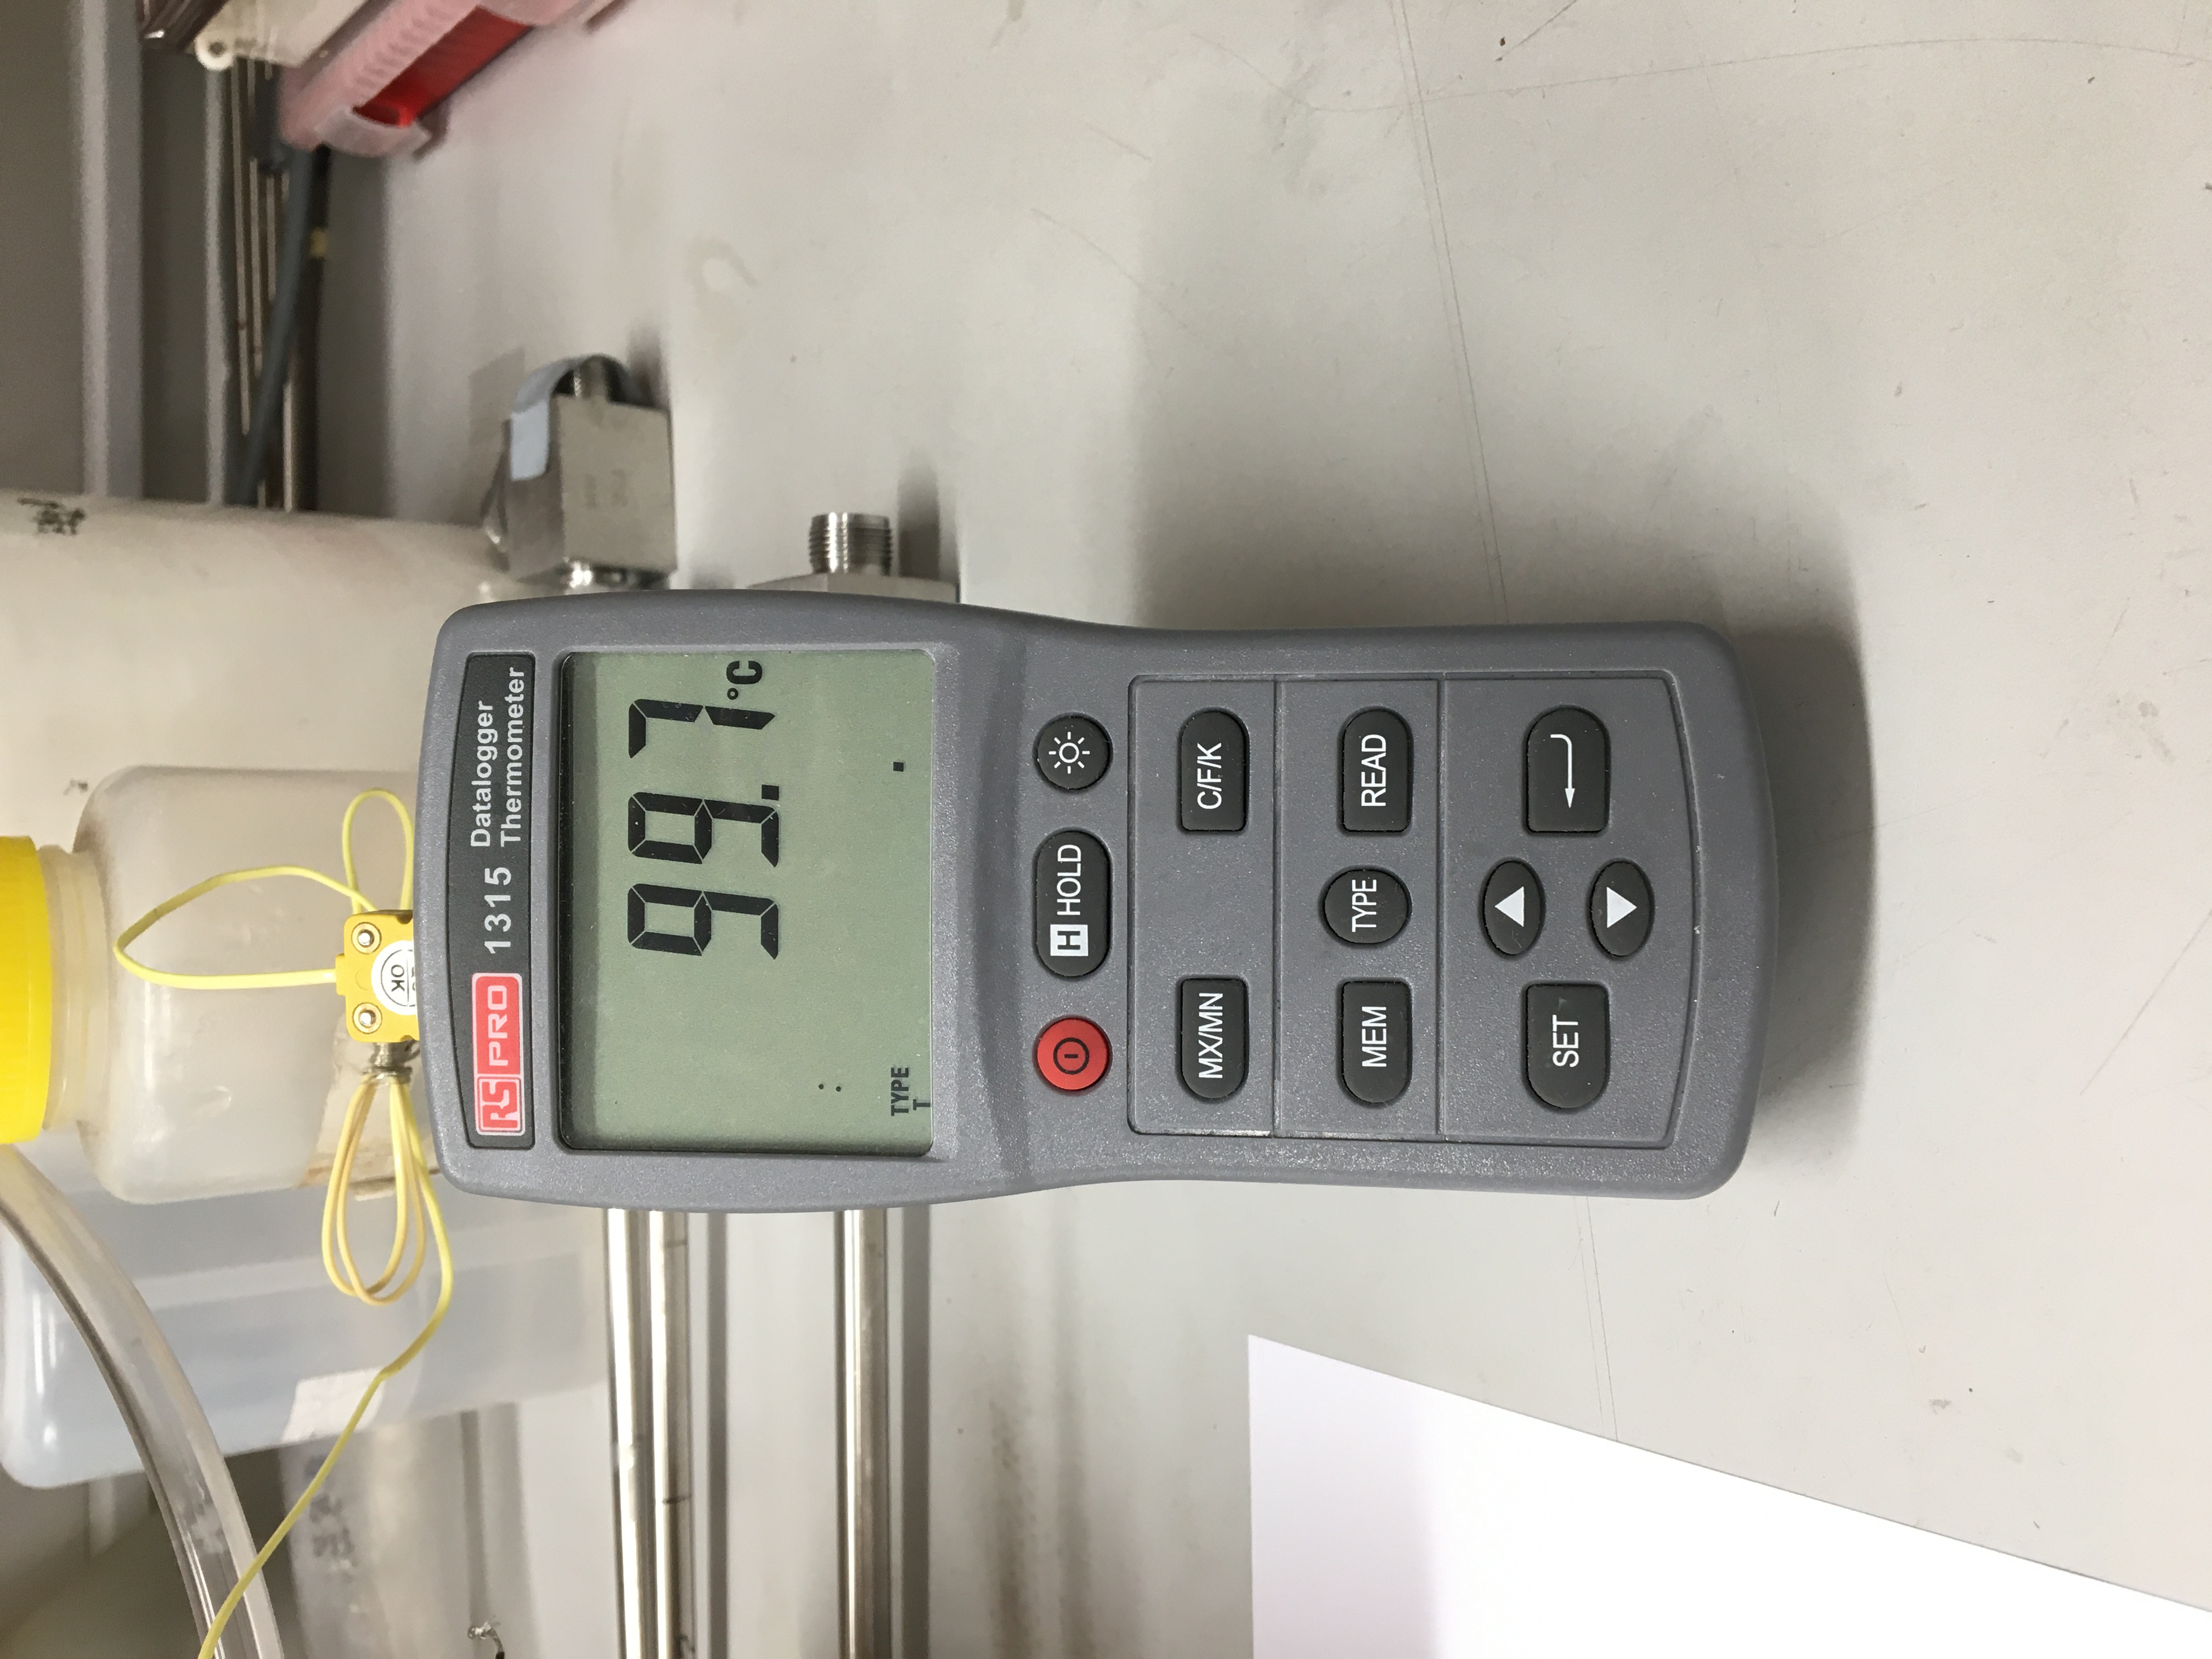

In [182]:
from IPython.display import Image
Image(filename = 'test.jpg',width = 800)